Karen Simonyan and Andrew Zisserman, “Very Deep Convolutional Networks for Large-Scale Image Recog- nition,” arXiv (2014), https://arxiv.org/abs/1409.1556

There are two ways to use a pretrained network: *feature extraction* and *fine-tuning*

## 1. Feature extraction

ConvNets used for image classification comprise 2 parts: convolutional base and densely connected classifier. Feature extraction = taking the convolutional base of the previously trained network, running the data through it, and training a new classifier on top of the output. This is because the representations learned by the convolution base are more generic and more reusable.







In [2]:
# Instantiating the VGG16 convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                 input_shape = (150,150,3))


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

2 ways to go from here 
- Running the conv base over your dataset, recording its output to a Numpy array on disk
- Extending the model by adding Dense layers on top, and running the whole thing end to end on the input data. This allows data augmentation


### Fast feature extraction without Data Augmentation



In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/anhpham/Projects/DLWP_Manning/Chapter5/Dogs-vs-Cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150,150),
        batch_size=batch_size,
        class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i += 1
        if i*batch_size>=sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
'''
The extracted features are of shape (samples,4,4,512).
These have to be flattened before being fed to the densely 
connected classifier
'''

train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000,4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

# Defining and training the densely connected classifier

from keras import models
from keras import layers
from keras import optimizers 

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
              loss ='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                   validation_data = (validation_features, validation_labels))



Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5884 - acc: 0.6760 - val_loss: 0.4320 - val_acc: 0.8520
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4225 - acc: 0.8080 - val_loss: 0.3630 - val_acc: 0.8500
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3516 - acc: 0.8485 - val_loss: 0.3207 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3194 - acc: 0.8625 - val_loss: 0.2982 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2856 - acc: 0.8815 - val_loss: 0.2839 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2640 - acc: 0.8935 - val_loss: 0.2729 - val_acc: 0.8830
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2509 - acc: 0.8980 - val_loss: 0.2633 - val_acc: 0.8870
Epoch 8/30
200

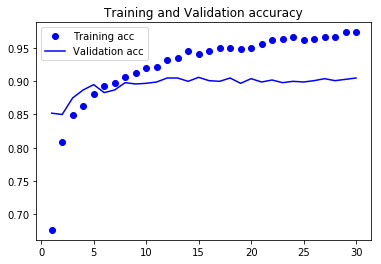

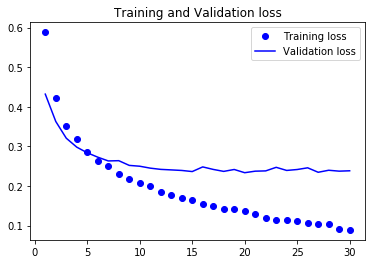

In [15]:
# Plotting results

import matplotlib.pyplot as plt

plt.clf()

acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc,'b', label = "Validation acc")
plt.title('Training and Validation accuracy')

plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and Validation loss")
plt.legend()

plt.show()



For Feature Extraction with Data Augmentation, since it is computationally expesinve -> use AWS GPU instance instead

Models behave just like layers => add conv_base in model

In [3]:
# Adding a densely connected classifier on top of the convolutional base
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before compiling and training the model: freeze the convolutional base to prevent their weights from being updated during training. If this step is not done, the represenations that were previously learned by the convolutional base will be modified during training. 

In Keras, this can be done by setting the network *trainable* attribute to False:

In [5]:
conv_base.trainable = False

In [ ]:
# Training the model end to end with a frozen convolutional base
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # validation data shouldn't be augmeneted

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=2e-5),
             metrics = ['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps=50)



## 2. Fine Tuning

This is complementary to feature extraction. Fine tuning consists of unfreezing a few of the top layers of the frozen model base used for feature extraction and jointly training both the newly added part of the model and these top layers. It is a must to freeze the convolution base of VGG16 in order to train a randomly initialized classifier on top. And it's only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. 

The steps for fine-tuning a network;
1. Add your custom network on top of an already-trained base network
2. Freeze your base net-work
3. Train the part you added
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part you added

The first 3 steps were done with feature extraction


Note
- It's more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers
- More parameters = higher risk of overfitting

In [10]:
# Freezing all layers up to a specific one
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Fine-tuning the model using RMSprop with a low learning rate 
# to avoid harming the represenations with too large updates

model.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs =100,
            validation_data=validation_generator,
            validation_steps=50)



NameError: name 'train_dir' is not defined

In [ ]:
# Smoothing the plots by replacing every loss and accuracy with exponential moving averages of these quantities

plt.clf()

def smooth_curve(points, factor = 0.8):
    smoothed_points =[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
        smooth_curve(acc),'bo',labels ='Smoothed training acc')
plt.plot(epochs,
        smooth_curve(val_acc),'b',labels = 'Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Wrapping up

- Convnets are the best type of machine-learning models for computer-vision tasks. It's possible to train from scratch even on a very small dataset with decent results
- On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when you're working wiht image data
- It's easy to reuse an existing convnet on a new dataset via feature extraction. This is a valuabel technique for working with small image datasets.
- As a complement to feature extraction, you can use fine-tuning, which adapts to a new problem some of the represenations previously learned by an existing model. This pushes performance a bit further.